In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from tqdm import tqdm


device = 'cuda'

mnist_train = torchvision.datasets.MNIST(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(
    'D:/data', train=False, transform=transforms.ToTensor(), download=True)


버전에 민감해서 아래의 코드를 추가해준다.

In [ ]:
# import PIL 
# PIL.Image.ANTIALIAS = PIL.Image.LANCZOS
# Image.Resampling.ANTIALIAS = Image.Resampling.LANCZOS

In [2]:
bce_loss = nn.BCEWithLogitsLoss()

def gan_loss(prediction, is_real):
    target = torch.ones_like(prediction) if is_real else torch.zeros_like(prediction)
    return bce_loss(prediction, target)


In [4]:
class MlpGenerator(nn.Module):
    def __init__(self, x_shape, z_dim=64):
        super().__init__()
        self.x_shape = x_shape
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Linear(self.z_dim, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, int(np.prod(self.x_shape))),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z).view(z.shape[0], *self.x_shape)

class MlpDiscriminator(nn.Module):
    def __init__(self, x_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(np.prod(x_shape)), 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        x = 2 * x - 1 # 별건 아니고 그냥 range를 [0,1]에서 [-1,1]로 만들어준거. mean이 0이 돼야 학습이 좀 더 잘 됨.
        return self.net(x.view(x.shape[0], -1))


  3%|▎         | 994/30000 [00:15<06:32, 73.87it/s] 

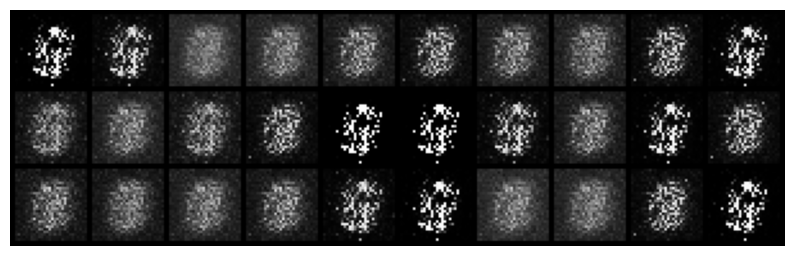

  7%|▋         | 1999/30000 [00:29<05:16, 88.49it/s] 

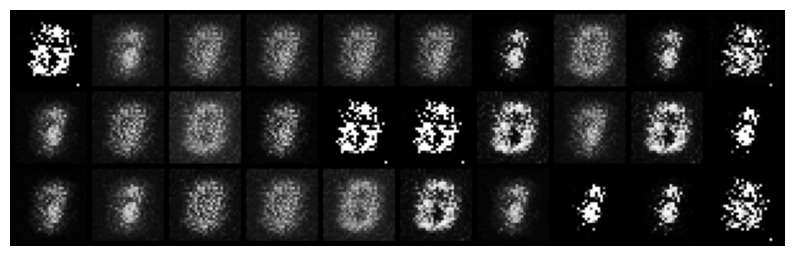

 10%|▉         | 2993/30000 [00:43<07:40, 58.60it/s] 

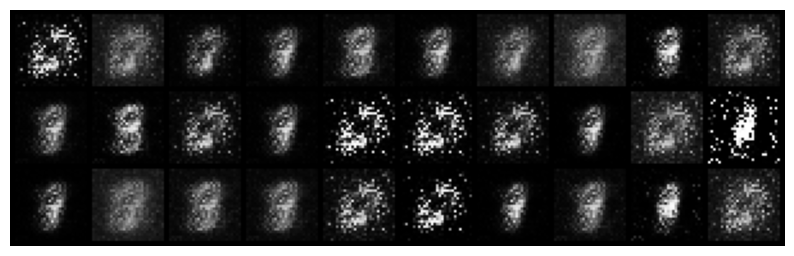

 13%|█▎        | 3999/30000 [00:58<06:42, 64.58it/s] 

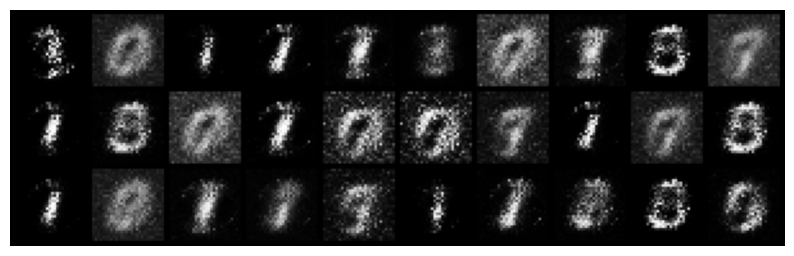

 17%|█▋        | 4994/30000 [01:13<05:00, 83.28it/s] 

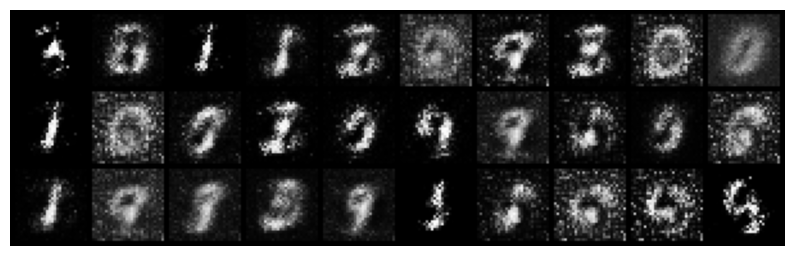

 20%|█▉        | 5988/30000 [01:22<02:58, 134.64it/s]

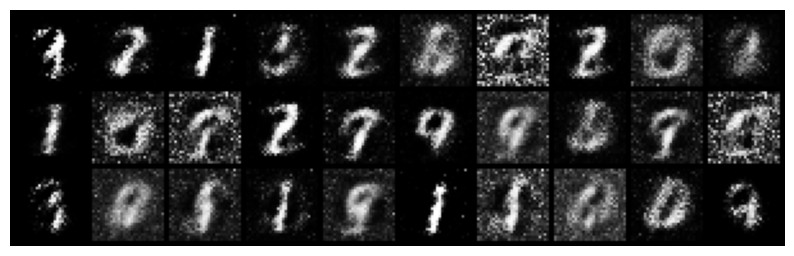

 23%|██▎       | 6999/30000 [01:31<02:54, 131.83it/s]

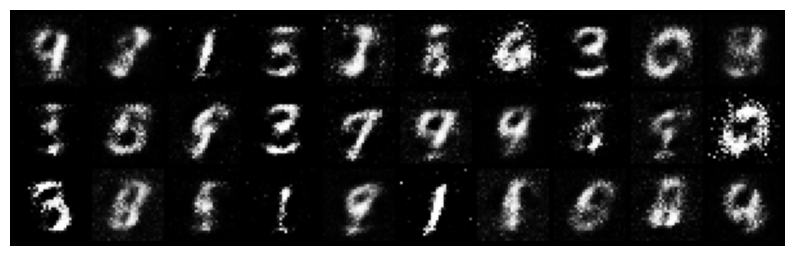

 27%|██▋       | 7998/30000 [01:42<04:38, 79.14it/s] 

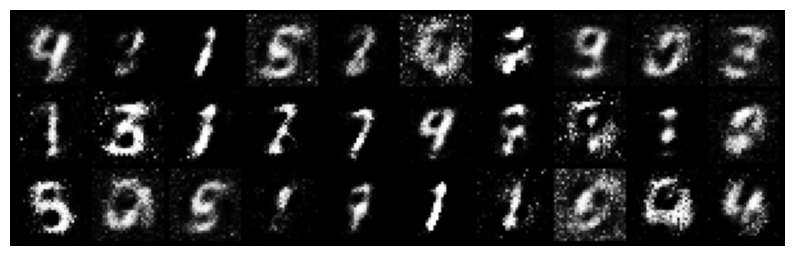

 30%|██▉       | 8994/30000 [01:51<03:56, 88.68it/s] 

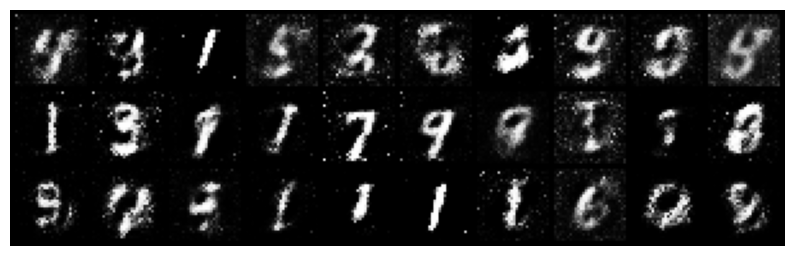

 33%|███▎      | 9999/30000 [02:00<02:57, 112.90it/s]

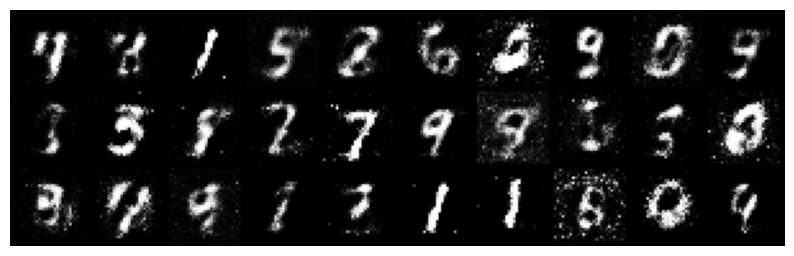

 37%|███▋      | 10995/30000 [02:09<02:57, 107.02it/s]

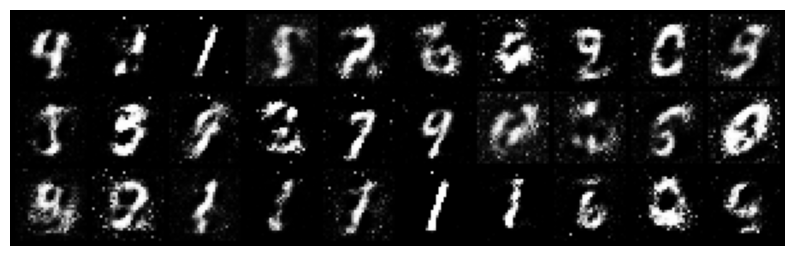

 40%|███▉      | 11992/30000 [02:19<02:54, 103.29it/s]

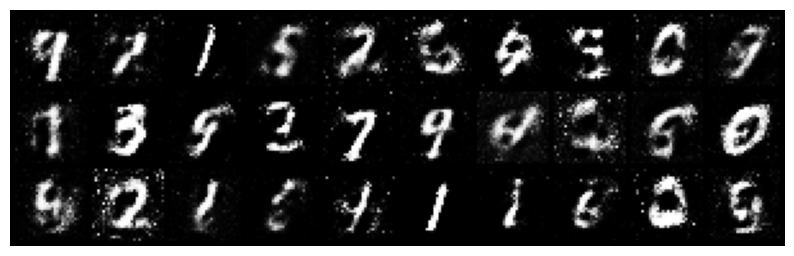

 43%|████▎     | 12990/30000 [02:32<03:05, 91.51it/s] 

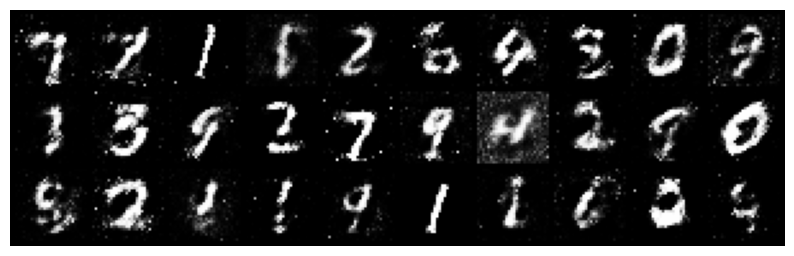

 47%|████▋     | 13996/30000 [02:41<02:24, 110.94it/s]

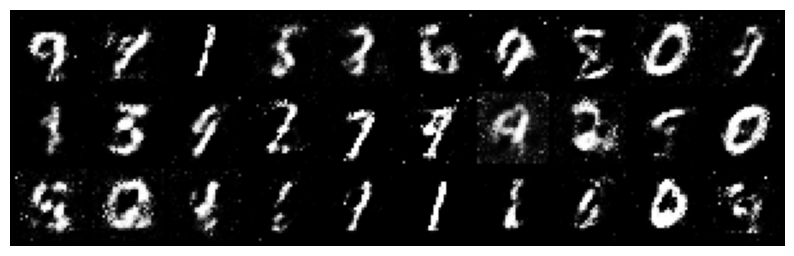

 50%|████▉     | 14992/30000 [02:52<02:15, 110.52it/s]

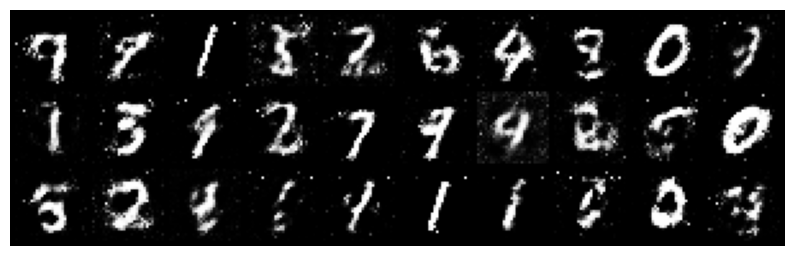

 53%|█████▎    | 15996/30000 [03:01<02:12, 105.98it/s]

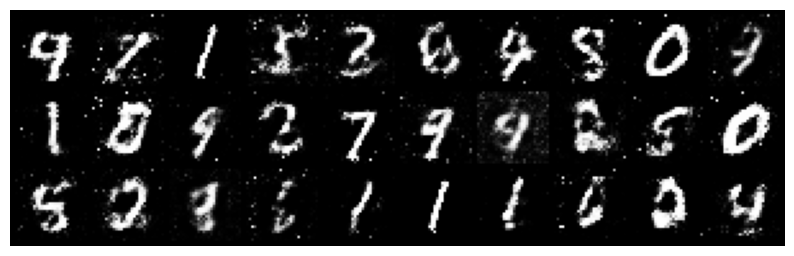

 57%|█████▋    | 16990/30000 [03:11<01:40, 128.84it/s]

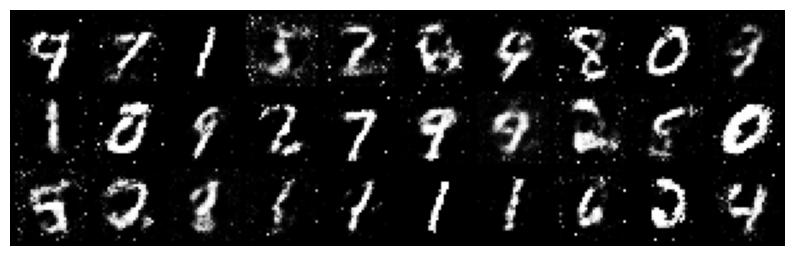

 60%|█████▉    | 17998/30000 [03:22<03:31, 56.73it/s] 

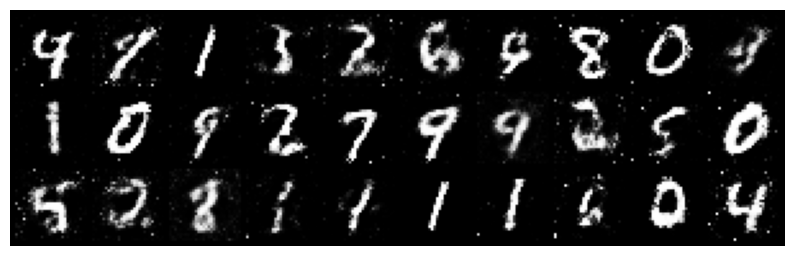

 63%|██████▎   | 18992/30000 [03:34<02:22, 77.51it/s] 

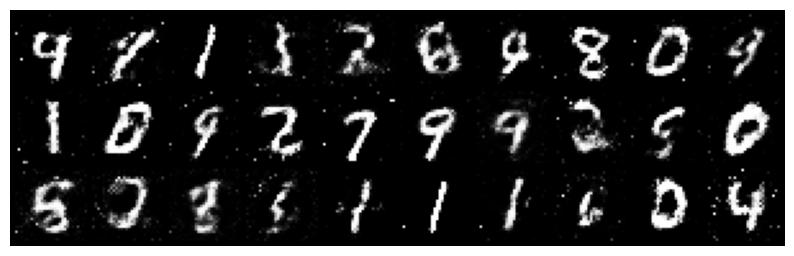

 67%|██████▋   | 19997/30000 [03:46<01:32, 107.76it/s]

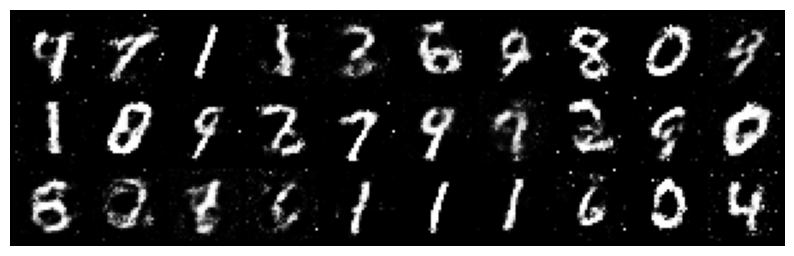

 70%|██████▉   | 20999/30000 [03:59<01:27, 103.03it/s]

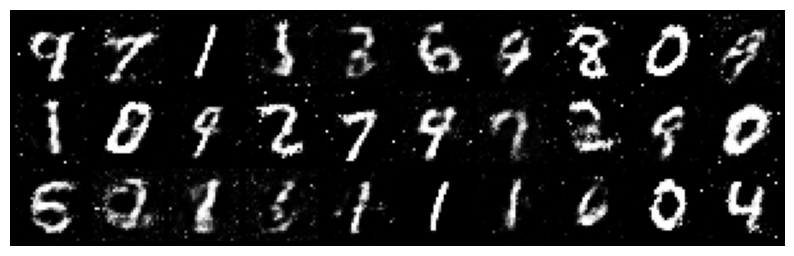

 73%|███████▎  | 21996/30000 [04:13<01:33, 85.23it/s] 

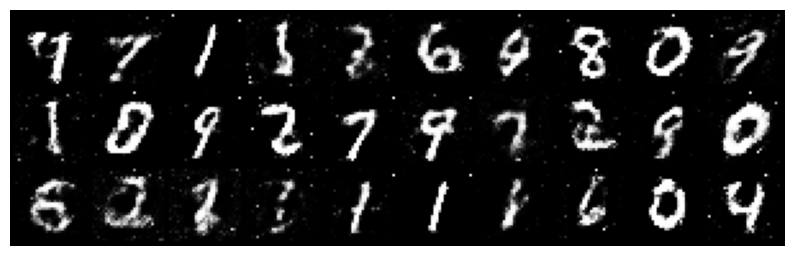

 77%|███████▋  | 22995/30000 [04:24<01:16, 92.02it/s] 

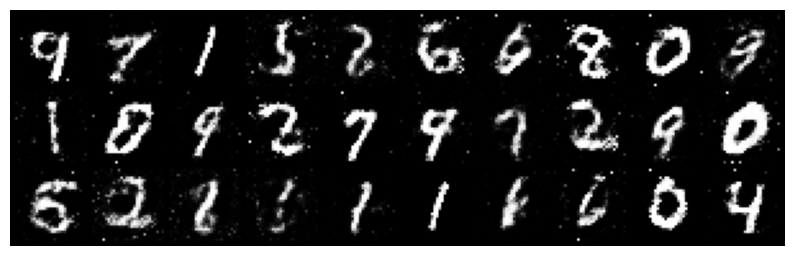

 80%|███████▉  | 23991/30000 [04:39<01:13, 81.72it/s]

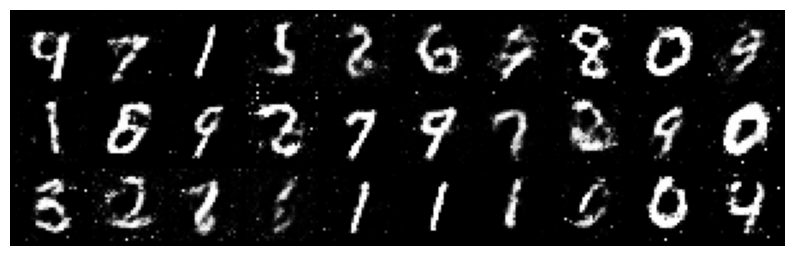

 83%|████████▎ | 24996/30000 [04:51<00:46, 106.99it/s]

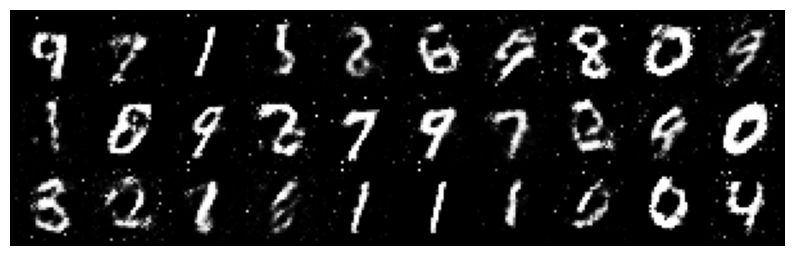

 87%|████████▋ | 25993/30000 [05:02<00:31, 127.36it/s]

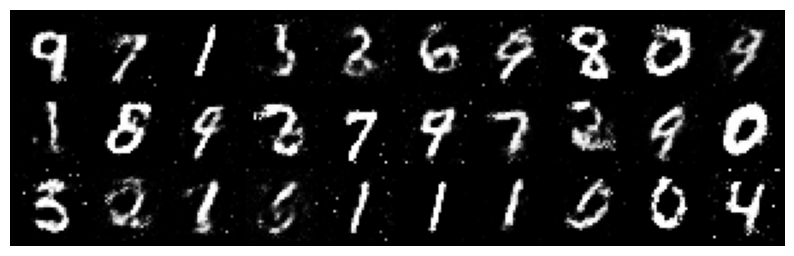

 90%|████████▉ | 26987/30000 [05:14<00:26, 115.35it/s]

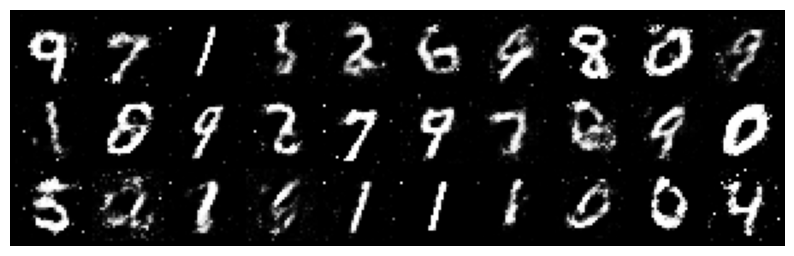

 93%|█████████▎| 27993/30000 [05:23<00:23, 86.44it/s] 

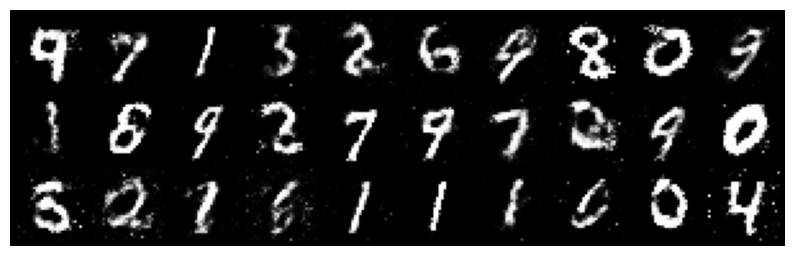

 97%|█████████▋| 28992/30000 [05:34<00:09, 103.39it/s]

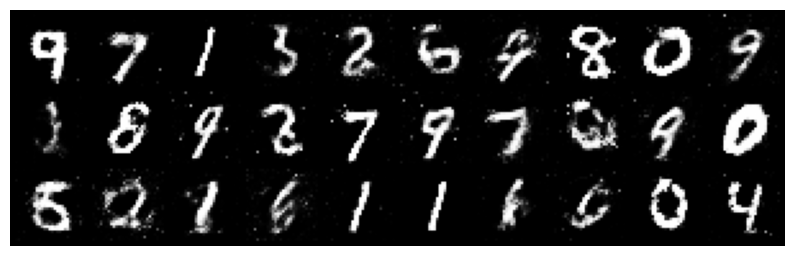

100%|█████████▉| 29991/30000 [05:45<00:00, 87.71it/s] 

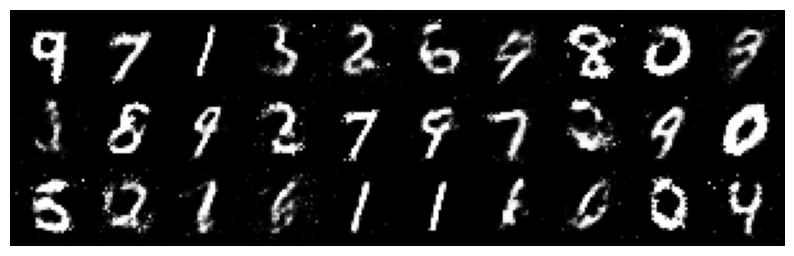

100%|██████████| 30000/30000 [05:46<00:00, 86.65it/s]


In [15]:
import matplotlib.pyplot as plt
log_dir = 'log/mnist-mlp_gan'
g = MlpGenerator((1, 28, 28), 64).to(device)
d = MlpDiscriminator((1, 28, 28)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.001)
optimizer_d = optim.Adam(d.parameters(), lr=0.001)
writer = SummaryWriter(log_dir)

sampler = RandomSampler(mnist_train,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    mnist_train, batch_size=100, sampler=sampler, num_workers=2)

z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, (x_real, _) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z)
    v_real = d(x_real)
    v_fake = d(x_fake)

    loss_d = torch.mean(F.relu(1.0 - v_real)) + torch.mean(F.relu(1.0 + v_fake))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z)
    v_fake = d(x_fake)

    loss_g = -torch.mean(v_fake)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 1000 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        # writer.add_image('generation', sample_grid, step)
        sample_grid = sample_grid.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(sample_grid)
        plt.axis('off')  # Remove axes
        plt.show()


In [17]:
%load_ext tensorboard
%tensorboard --logdir log/mnist-mlp_gan

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16444), started 0:00:18 ago. (Use '!kill 16444' to kill it.)

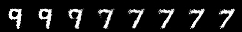

In [18]:
n = 8
z1 = sample_z[0].unsqueeze(0)
zn = sample_z[1].unsqueeze(0)
z = z1 + (zn - z1) * torch.linspace(0, 1, n, device=z1.device).view(-1, 1)
with torch.no_grad():
    g = g.eval()
    x = g(z)
transforms.functional.to_pil_image(torchvision.utils.make_grid(x, nrow=n))

### Conditional GAN
Can we give a condition to extract images for specific classes (0, 1, 2, ...)? How should we change the input and output of the generator and discriminator to make it possible?

In [6]:
class MlpConditionalGenerator(nn.Module):
    def __init__(self, x_shape, z_dim=64, num_classes=10):
        super().__init__()
        self.x_shape = x_shape
        self.z_dim = z_dim
        self.num_classes = num_classes
        flatten_image_size = x_shape[0] * x_shape[1] * x_shape[2]

        self.net = nn.Sequential(
            nn.Linear(z_dim + num_classes, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, flatten_image_size),
            nn.Sigmoid()
        )

    def forward(self, z, y):
        return self.net(torch.cat([z, F.one_hot(y, num_classes=self.num_classes)], dim=1)).view(z.shape[0], *self.x_shape)


class MlpConditionalDiscriminator(nn.Module):
    def __init__(self, x_shape, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        flatten_image_size = x_shape[0] * x_shape[1] * x_shape[2]

        self.net = nn.Sequential(
            nn.Linear(flatten_image_size + num_classes, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 1)
        )

    def forward(self, x, y):
        x = 2 * x - 1
        return self.net(torch.cat([x.view(x.shape[0], -1), F.one_hot(y, num_classes=self.num_classes)], dim=1))


In [20]:
y = torch.LongTensor([1,2,3])
F.one_hot(y, num_classes=10)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [23]:
import PIL 
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS

In [ ]:
log_dir = 'log/mnist-mlp_conditional_gan'
g = MlpConditionalGenerator((1, 28, 28), 64).to(device)
d = MlpConditionalDiscriminator((1, 28, 28)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.001)
optimizer_d = optim.Adam(d.parameters(), lr=0.001)
writer = SummaryWriter(log_dir)

sampler = RandomSampler(mnist_train,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    mnist_train, batch_size=100, sampler=sampler, num_workers=2)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, (x_real, y_real) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    y_real = y_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z, y_real)
    v_real = d(x_real, y_real)
    v_fake = d(x_fake, y_real)

    loss_d = 0.5 * (gan_loss(v_real, True) + gan_loss(v_fake, False))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z, y_real)
    v_fake = d(x_fake, y_real)

    loss_g = gan_loss(v_fake, True)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z, torch.arange(0, 30, dtype=torch.long, device=device) % 10).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        # writer.add_image('generation', sample_grid, step)
        sample_grid = sample_grid.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(sample_grid)
        plt.axis('off')  # Remove axes
        plt.show()

100%|██████████| 30000/30000 [05:32<00:00, 90.27it/s] 


In [26]:
%reload_ext tensorboard
%tensorboard --logdir log/mnist-mlp_conditional_gan

Reusing TensorBoard on port 6006 (pid 15044), started 0:00:02 ago. (Use '!kill 15044' to kill it.)

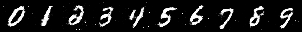

In [27]:
z = z_prior.sample([1, g.z_dim]) * torch.ones(10, 1, device=device)
g = g.eval()
with torch.no_grad():
    x = g(z, torch.arange(10, dtype=torch.long, device=device))
transforms.functional.to_pil_image(torchvision.utils.make_grid(x, nrow=10))

To give our discriminator (and consequently our generator) more guidance/supervision, we can also train the discriminator to classify which class (i.e., number in our case) the real and generated samples belong to

In [7]:
class MlpDiscriminatorWithClassifier(nn.Module):
    def __init__(self, x_shape, num_classes=10):
        super().__init__()
        flatten_image_size = x_shape[0] * x_shape[1] * x_shape[2]

        self.net = nn.Sequential(
            nn.Linear(flatten_image_size, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1),
            nn.Linear(200, 1 + num_classes)
        )

    def forward(self, x):
        x = 2 * x - 1
        return self.net(x.view(x.shape[0], -1))


In [10]:
log_dir = 'log/mnist-mlp_classifier_gan'
g = MlpConditionalGenerator((1, 28, 28), 64).to(device)
d = MlpDiscriminatorWithClassifier((1, 28, 28)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.001)
optimizer_d = optim.Adam(d.parameters(), lr=0.001)
writer = SummaryWriter(log_dir)

sampler = RandomSampler(mnist_train,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    mnist_train, batch_size=100, sampler=sampler)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

criterion = nn.CrossEntropyLoss()
for step, (x_real, y_real) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    y_real = y_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z, y_real)
    v_real = d(x_real)
    v_fake = d(x_fake)

    loss_d = 1 / 3 * (gan_loss(v_real[:, :1], True) + gan_loss(v_fake[:, :1], False) + criterion(v_real[:, 1:], y_real))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z, y_real)
    v_fake = d(x_fake)

    loss_g = 0.5 * (gan_loss(v_fake[:, :1], True) + criterion(v_fake[:, 1:], y_real))
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z, torch.arange(0, 30, dtype=torch.long, device=device) % 10).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        writer.add_image('generation', sample_grid, step)
        # sample_grid = sample_grid.permute(1, 2, 0).cpu().numpy()
        # plt.figure(figsize=(10, 10))
        # plt.imshow(sample_grid)
        # plt.axis('off')  # Remove axes
        # plt.show()

100%|██████████| 30000/30000 [03:03<00:00, 163.17it/s]


In [12]:
%reload_ext tensorboard
%tensorboard --logdir log/mnist-mlp_classifier_gan

Reusing TensorBoard on port 6006 (pid 18908), started 0:00:01 ago. (Use '!kill 18908' to kill it.)

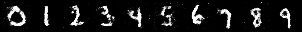

In [13]:
z = z_prior.sample([1, g.z_dim]) * torch.ones(10, 1, device=device)
g = g.eval()
with torch.no_grad():
    x = g(z, torch.arange(10, dtype=torch.long, device=device))
transforms.functional.to_pil_image(torchvision.utils.make_grid(x, nrow=10))

# Exercise

Try unconditional GAN on the CIFAR10 dataset. Compare the results with the MNIST dataset

In [19]:
# TODO: CIFAR10-MLP_GAN
log_dir = 'log/cifar10-mlp_gan'

# TODO 1:
# load dataset and make dataloader
train = torchvision.datasets.CIFAR10(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)
test = torchvision.datasets.CIFAR10(
    'D:/data', train=False, transform=transforms.ToTensor(), download=True)
# TODO 2:
# create model
# hint: you don't have to define new model class. just reuse existing (unconditional) generator and discriminator
# with differnt x_shape

# TODO 3:
# training code
log_dir = 'log/cifar10-mlp_gan'
g = MlpConditionalGenerator((3, 32, 32), 64).to(device)
d = MlpConditionalDiscriminator((3, 32, 32)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.001)
optimizer_d = optim.Adam(d.parameters(), lr=0.001)
writer = SummaryWriter(log_dir)

sampler = RandomSampler(train,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    train, batch_size=100, sampler=sampler, num_workers=2)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, (x_real, y_real) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    y_real = y_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z, y_real)
    v_real = d(x_real, y_real)
    v_fake = d(x_fake, y_real)

    loss_d = 0.5 * (gan_loss(v_real, True) + gan_loss(v_fake, False))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z, y_real)
    v_fake = d(x_fake, y_real)

    loss_g = gan_loss(v_fake, True)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z, torch.arange(0, 30, dtype=torch.long, device=device) % 10).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        writer.add_image('generation', sample_grid, step)
        # sample_grid = sample_grid.permute(1, 2, 0).cpu().numpy()
        # plt.figure(figsize=(10, 10))
        # plt.imshow(sample_grid)
        # plt.axis('off')  # Remove axes
        # plt.show()


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 30000/30000 [01:54<00:00, 261.11it/s]


In [20]:
%load_ext tensorboard
%tensorboard --logdir log/cifar10-mlp_gan

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 17340), started 0:03:14 ago. (Use '!kill 17340' to kill it.)

## DCGAN on CIFAR10

### What is DCGAN?

A [DCGAN](https://arxiv.org/abs/1511.06434) (Radford et al., 2015) is a direct extension of the GAN described above, except that it explicitly uses convolutional and transposed convolutional layers in the discriminator and generator, respectively.
The paper also provides analysis on GAN and other tricks for better training GAN using convolutional networks.


ConvTransposed2d: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

Illustration of transposed conv: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [21]:
class DcganGenerator(nn.Module):
    def __init__(self, x_shape, z_dim=64):
        super().__init__()

        self.z_dim = z_dim

        ngf = 64
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            # (z_dim, 1, 1) -> (ngf * 4, 4, 4) -> (ngf * 2, 8, 8) -> (ngf, 16, 16) -> (num_channel, 32, 32)
            # Use <ConvTranspose2d(kernel_size=4) + BatchNorm2d + ReLU>
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, x_shape[0], 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 32 x 32
        )

    def forward(self, z):
        return self.net(z.view(z.shape[0], z.shape[1], 1, 1))


class DcganDiscriminator(nn.Module):
    def __init__(self, x_shape):
        super().__init__()

        ndf = 64
        self.net = nn.Sequential(
            # (num_channel, 32, 32) -> (ndf, 16, 16) -> (ndf * 2, 8, 8) -> (ndf * 4, 4, 4) -> (1, 1, 1)
            # Use <Conv2d(kernel_size=4) + BatchNorm2d + LeakyReLU(0.2)>
            # input is (nc) x 32 x 32
            nn.Conv2d(x_shape[0], ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        x = 2 * x - 1
        return self.net(x).view(x.shape[0], 1)

In [23]:
log_dir = 'log/cifar10-dcgan'
g = DcganGenerator((3, 32, 32), 64).to(device)
d = DcganDiscriminator((3, 32, 32)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
writer = SummaryWriter(log_dir)

cifar10 = torchvision.datasets.CIFAR10(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)

sampler = RandomSampler(cifar10,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    cifar10, batch_size=100, sampler=sampler, num_workers=2)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, (x_real, _) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z)
    v_real = d(x_real)
    v_fake = d(x_fake)

    loss_d = (gan_loss(v_real, True) + gan_loss(v_fake, False)) * 0.5
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z)
    v_fake = d(x_fake)

    loss_g = gan_loss(v_fake, True)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        writer.add_image('generation', sample_grid, step)

Files already downloaded and verified


100%|██████████| 30000/30000 [03:38<00:00, 137.50it/s]


In [25]:
%reload_ext tensorboard
%tensorboard --logdir log/cifar10-dcgan

Reusing TensorBoard on port 6008 (pid 7484), started 0:00:02 ago. (Use '!kill 7484' to kill it.)

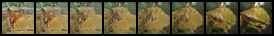

In [26]:
n = 8
z1 = sample_z[0].unsqueeze(0)
zn = sample_z[1].unsqueeze(0)
z = z1 + (zn - z1) * torch.linspace(0, 1, n, device=z1.device).view(-1, 1)
with torch.no_grad():
    g = g.eval()
    x = g(z)
transforms.functional.to_pil_image(torchvision.utils.make_grid(x, nrow=n))

### Conditional DCGAN on CIFAR10

In [27]:
class DcganConditionalGenerator(nn.Module):
    def __init__(self, x_shape, z_dim=64, num_classes=10):
        super().__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes

        ngf = 64
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            # (z_dim, 1, 1) -> (ngf * 4, 4, 4) -> (ngf * 2, 8, 8) -> (ngf, 16, 16) -> (num_channel, 32, 32)
            # Use <ConvTranspose2d(kernel_size=4) + BatchNorm2d + ReLU>
            nn.ConvTranspose2d(z_dim + num_classes, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, x_shape[0], 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 32 x 32
        )

    def forward(self, z, y):
        return self.net(torch.cat([z, F.one_hot(y, num_classes=self.num_classes)], dim=1).view(z.shape[0], -1, 1, 1))


class DcganConditionalDiscriminator(nn.Module):
    def __init__(self, x_shape, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        ndf = 64
        self.net = nn.Sequential(
            # (num_channel, 32, 32) -> (ndf, 16, 16) -> (ndf * 2, 8, 8) -> (ndf * 4, 4, 4) -> (1, 1, 1)
            # Use <Conv2d(kernel_size=4) + BatchNorm2d + LeakyReLU(0.2)>
            # input is (nc) x 32 x 32
            nn.Conv2d(x_shape[0] + num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x, y):
        x = 2 * x - 1
        # F.one_hot(y, num_classes=self.num_classes).view(y.shape[0], self.num_classes, 1, 1) -> shape (B, 10, 1, 1)
        # torch.ones_like(x[:, :1]) -> tensor whose values are ones and with shape (B, 1, H, W)
        label_info = F.one_hot(y, num_classes=self.num_classes).view(y.shape[0], self.num_classes, 1, 1) * torch.ones_like(x[:, :1])
        return self.net(torch.cat([x, label_info], dim=1)).view(x.shape[0], 1)

In [32]:
log_dir = 'log/cifar10-conditional-dcgan'
g = DcganConditionalGenerator((3, 32, 32), 64).to(device)
d = DcganConditionalDiscriminator((3, 32, 32)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
writer = SummaryWriter(log_dir)

cifar10 = torchvision.datasets.CIFAR10(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)

sampler = RandomSampler(cifar10,
                        replacement=True,
                        num_samples=100 * 30000)
train_loader = DataLoader(
    cifar10, batch_size=100, sampler=sampler, num_workers=2)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, (x_real, y_real) in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    y_real = y_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z, y_real)
    v_real = d(x_real, y_real)
    v_fake = d(x_fake, y_real)

    loss_d = 0.5 * (gan_loss(v_real, True) + gan_loss(v_fake, False))
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z, y_real)
    v_fake = d(x_fake, y_real)

    loss_g = gan_loss(v_fake, True)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z, torch.arange(0, 30, dtype=torch.long, device=device) % 10).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        writer.add_image('generation', sample_grid, step)

Files already downloaded and verified


100%|██████████| 30000/30000 [03:58<00:00, 125.71it/s]


In [34]:
%reload_ext tensorboard
%tensorboard --logdir log/cifar10-conditional-dcgan
# plane, car, bird, cat, deer, dog, frog, horse, ship, truck

Reusing TensorBoard on port 6009 (pid 6584), started 0:04:35 ago. (Use '!kill 6584' to kill it.)

In [ ]:
z = z_prior.sample([1, g.z_dim]) * torch.ones(10, 1, device=device)
g = g.eval()
with torch.no_grad():
    x = g(z, torch.arange(10, dtype=torch.long, device=device))
transforms.functional.to_pil_image(torchvision.utils.make_grid(x, nrow=10))
# plane, car, bird, cat, deer, dog, frog, horse, ship, truck

## DCGAN on CelebA



In [ ]:
!gdown https://drive.google.com/uc?id=1_MUqdZQyNcWoXeo_M3P7swFoHwQQpyi9
!unzip -qq celeba_64x64.zip

In [ ]:
import os
from PIL import Image


class CelebA(Dataset):
    def __init__(self, image_dir, transform=None):
        self.transform = transform

        self.items = [
            os.path.join(image_dir, name)
            for name in os.listdir(image_dir)
        ]

    def __getitem__(self, index):
        image = Image.open(self.items[index]).convert('RGB')
        if self.transform is not None:
            return self.transform(image)
        return image

    def __len__(self):
        return len(self.items)

celeba = CelebA('celeba_64x64', transform=transforms.ToTensor())

In [ ]:
class DcganGenerator(nn.Module):
    def __init__(self, x_shape, z_dim=64):
        super().__init__()

        self.z_dim = z_dim

        ngf = 64
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            # (z_dim, 1, 1) -> (ngf * 8, 4, 4) -> (ngf * 4, 8, 8) -> (ngf * 2, 16, 16) -> (ngf, 32, 32) -> (num_channel, 64, 64)
            # Use <ConvTranspose2d(kernel_size=4) + BatchNorm2d + ReLU>
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, x_shape[0], 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z):
        return self.net(z.view(z.shape[0], z.shape[1], 1, 1))


class DcganDiscriminator(nn.Module):
    def __init__(self, x_shape):
        super().__init__()

        ndf = 64
        self.net = nn.Sequential(
            # (num_channel, 64, 64) -> (ndf, 32, 32) -> (ndf * 2, 16, 16) -> (ndf * 4, 8, 8) -> (ndf * 8, 4, 4) -> (1, 1, 1)
            # Use <Conv2d(kernel_size=4) + BatchNorm2d + LeakyReLU(0.2)>
            # input is (nc) x 64 x 64
            nn.Conv2d(x_shape[0], ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        x = 2 * x - 1
        return self.net(x).view(x.shape[0], 1)

In [ ]:
log_dir = 'log/celeba-dcgan'
g = DcganGenerator((3, 64, 64), 64).to(device)
d = DcganDiscriminator((3, 64, 64)).to(device)
optimizer_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
writer = SummaryWriter(log_dir)

sampler = RandomSampler(celeba,
                        replacement=True,
                        num_samples=100 * 20000)
train_loader = DataLoader(
    celeba, batch_size=100, sampler=sampler, num_workers=2)

# 30 generation samples
z_prior = torch.distributions.Normal(torch.zeros([], device=device), 1)
sample_z = z_prior.sample([30, g.z_dim])

for step, x_real in enumerate(tqdm(train_loader), start=1):
    ########################
    # Update discriminator #
    ########################
    g = g.train()

    x_real = x_real.to(device)
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    with torch.no_grad():
        x_fake = g(z)
    v_real = d(x_real)
    v_fake = d(x_fake)

    loss_d = (gan_loss(v_real, True) + gan_loss(v_fake, False)) * 0.5
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

    ####################
    # Update generator #
    ####################
    z = z_prior.sample([x_real.shape[0], g.z_dim])
    x_fake = g(z)
    v_fake = d(x_fake)

    loss_g = gan_loss(v_fake, True)
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

    # Train summary
    if step % 100 == 0:
        writer.add_scalar('loss/g', loss_g, step)
        writer.add_scalar('loss/d', loss_d, step)

        # Summarize generation samples
        g = g.eval()
        with torch.no_grad():
            x_fake = g(sample_z).view(-1, *x_real.shape[1:])
        sample_grid = make_grid(x_fake, nrow=10)
        writer.add_image('generation', sample_grid, step)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir log/celeba-dcgan

In [ ]:
g = g.eval()
with torch.no_grad():
    x_fake = g(sample_z).view(-1, *x_real.shape[1:])
sample_grid = make_grid(x_fake, nrow=10)
transforms.functional.to_pil_image(sample_grid)

After round ~10k training steps, the results are as below

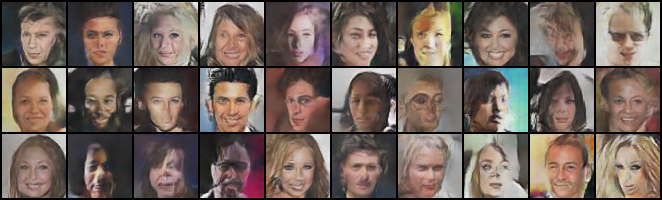

### Tricks to improve GAN training

- multiple (e.g., 4) discriminator updates for every one generator update
- using larger learning rate for discriminator
- progressively increasing image size

### Other Generative Models (papers/tutorials)
- StyleGAN: [paper](https://arxiv.org/abs/1812.04948)
- Annotated Diffusion: [tutorial](https://huggingface.co/blog/annotated-diffusion)
- Stable Diffusion: [paper](https://arxiv.org/abs/2112.10752)
- Instruct-NeRF2NeRF: [paper](https://arxiv.org/abs/2303.12789)